In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithm import *
from utils import get_backend_conectivity, RandomHamiltonian
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In this notebook we test the VQE class. First we load our IBM account and define the backends. 

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris) # Backend with noise model
NUM_SHOTS = 2**13  # Number of shots for each circuit

We create a Hamiltonian to perform the test.

In [3]:
# qubit_op, init_state = LiH(initial_state=True)
# num_qubits = qubit_op.num_qubits

In [4]:
num_qubits = 2
qubit_op = RandomHamiltonian( num_qubits, 6 )
init_state = QuantumCircuit(num_qubits)
print( qubit_op )

SummedOp([
  XZ,
  XY,
  ZX,
  ZX,
  XX,
  ZX
])


We calculate the minimum energy of the Hamiltonian by a classical method.

In [5]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-4.526066876907423-1.0250386925925712e-16j)

We will employ a Hardware efficient variation form.

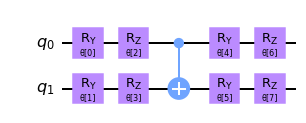

In [6]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

We define a callback function, to have the behavior of the algorithm by iterations.

In [7]:
def callback( evals, params, energy, extra  ):  
    display("{}, {}".format(evals,energy))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []
energies    = [] 

We select SPSA with 100 iterations as classical optimizer.

In [8]:
optimizer = SPSA( maxiter=100, last_avg=1 )

Initial parameters for the optimization

In [9]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [10]:
result_exact.eigenvalue 

(-4.526066876907423-1.0250386925925712e-16j)

VQE with entangled grouping

In [11]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.44921875


VQE with TPB grouping

In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.47265625


VQE with entangled grouping and the connectivity of ibmq_paris

In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.537109375


Testing callback function

In [14]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.548828125


Testing simulation with noise model

In [15]:
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.013671875


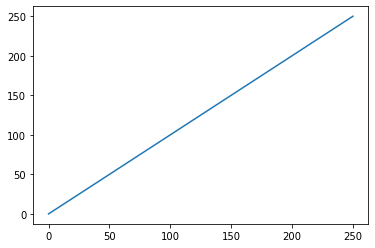

In [16]:
plt.plot( evaluations )

Testing quantum instance

In [17]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-4.5146484375


In [18]:
print(results)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 200),
                (   'eigenstate',
                    {   '00': 0.5585800916162337,
                        '01': 0.5044963840925919,
                        '10': 0.40864677595693816,
                        '11': 0.516216516771306}),
                ('eigenvalue', -4.5146484375),
                (   'optimal_parameters',
                    {   ParameterVectorElement(θ[0]): -1.4683367809015189,
                        ParameterVectorElement(θ[1]): 0.10277607565403969,
                        ParameterVectorElement(θ[2]): 0.07029435046652974,
                        ParameterVectorElement(θ[4]): -1.0864667701518012,
                        ParameterVectorElement(θ[5]): -0.3110230722571499,
                        ParameterVectorElement(θ[3]): -0.4715964648484042,
                        ParameterVectorElement(θ[6]): -0.09378644554290715,
                        ParameterVectorElement(θ[7]

Testing another function of the VQE class

In [19]:
solver.ansatz

In [20]:
solver.cleanup_parameterized_circuits

<bound method VariationalAlgorithm.cleanup_parameterized_circuits of <VQE.VQE object at 0x00000240B0E06648>>

In [21]:
solver.construct_expectation( pars, qubit_op )[0].draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌─┐   
q39390_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├─────┤M├───
          ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌───┐└╥┘┌─┐
q39390_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ H ├─╫─┤M├
          └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘ ║ └╥┘
   c48: 1/═══════════════════════════════════════════════════════════╬══╩═
                                                                     ║  0 
                                                                     ║    
   c49: 1/═══════════════════════════════════════════════════════════╩════
                                                                     0

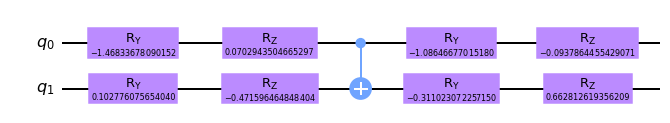

In [22]:
solver.get_optimal_circuit().draw(output='mpl')

In [23]:
solver.get_optimal_cost()

-4.5146484375

In [24]:
solver.get_optimal_vector()

{'00': 0.5653141410976732,
 '11': 0.5210416250166583,
 '01': 0.4923734767683978,
 '10': 0.4080489017875186}

In [25]:
# solver.get_prob_vector_for_params()

In [26]:
# solver.get_probabilities_for_counts()

In [27]:
solver.initial_point

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [28]:
solver.optimal_params

array([-1.46833678,  0.10277608,  0.07029435, -0.47159646, -1.08646677,
       -0.31102307, -0.09378645,  0.66281262])

In [29]:
solver.optimizer

In [30]:
solver.quantum_instance

In [31]:
solver.supports_aux_operators()

False

In [32]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz_params: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])]
-- ansatz:      ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘
-- quantum_instance: 
Qiskit Terra version: 0.17.0
Backend: 'aer_simulator_statevector (None)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 

In [33]:
import qiskit.tools.jupyter
%qiskit_version_table